<a href="https://colab.research.google.com/github/ISR-Labs/machine-failure-predication-/blob/main/code%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#  IMPORTING NEEDED LIBRARIES......

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from math import perm
from logging import warning
warning=('ignore')
print(f"pandas version is {pd.__version__}")
print(f"numpy version is {np.__version__}")
print(f"seaborn version is {sns.__version__}")



pandas version is 2.2.2
numpy version is 2.0.2
seaborn version is 0.13.2


In [2]:
# .... Loading & Exploring the data .....


data = pd.read_csv("/content/data (1).csv")
print("Data shape:", data.shape)
print("/nfirst few rows of data:")
print(data.head(100))
print("/nFailure Distribution:")
print(data['fail'].value_counts())

Data shape: (944, 10)
/nfirst few rows of data:
    footfall  tempMode  AQ  USS  CS  VOC  RP  IP  Temperature  fail
0          0         7   7    1   6    6  36   3            1     1
1        190         1   3    3   5    1  20   4            1     0
2         31         7   2    2   6    1  24   6            1     0
3         83         4   3    4   5    1  28   6            1     0
4        640         7   5    6   4    0  68   6            1     0
..       ...       ...  ..  ...  ..  ...  ..  ..          ...   ...
95        31         7   4    3   6    1  53   3            6     1
96        16         7   5    3   6    5  82   3            6     1
97        33         5   4    3   5    6  82   3            6     1
98         0         3   5    3   6    5  47   6            7     1
99         0         3   4    2   7    4  68   3            7     0

[100 rows x 10 columns]
/nFailure Distribution:
fail
0    551
1    393
Name: count, dtype: int64


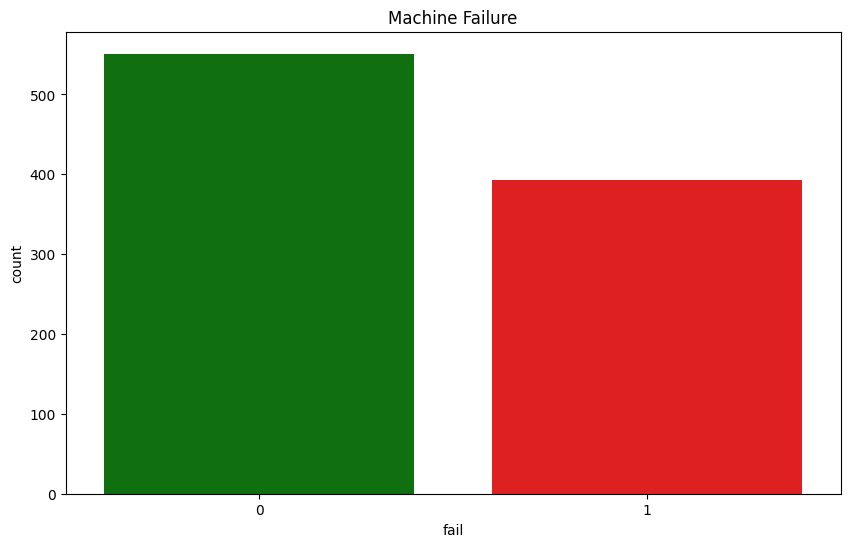

In [3]:
# ... VIsualizing the data ...


plt.figure(figsize=(10,6))
sns.countplot(data=data, x='fail', hue='fail', palette=['green','red'], legend=False)
plt.title('Machine Failure')
plt.show()

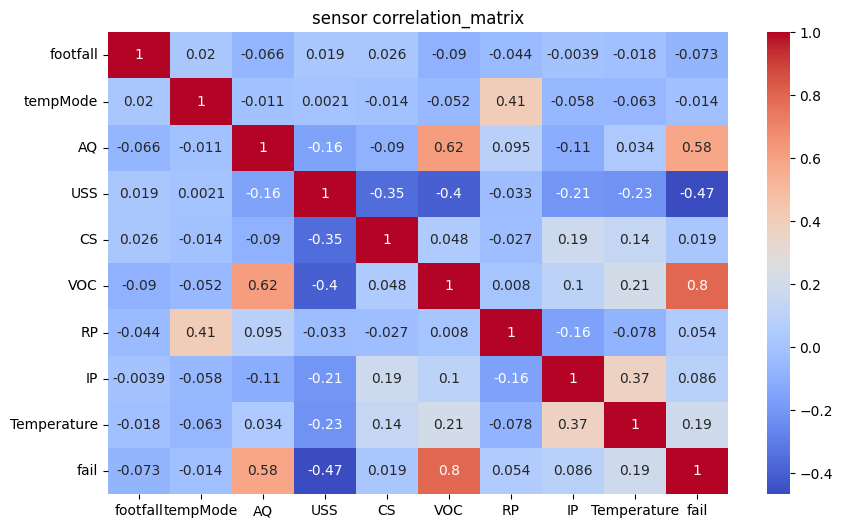

In [4]:
plt.figure(figsize=(10,6))
correlation_matrix=data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap= 'coolwarm')
plt.title('sensor correlation_matrix')
plt.show();

In [5]:
#.... preparing the data for machine learning.....


x = data[['footfall', 'tempMode', 'AQ', 'USS', 'CS',
          'VOC', 'RP', 'IP', 'Temperature']]
y = data['fail']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

#.. spliting the data into 65% training 12% validation 23% testing ..
x_train, x_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.35, random_state=42, stratify = y)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=2/3, random_state=42, stratify = y_temp)

print(f"nsplit sizes:")
print(f"Training: {len(x_train)}")
print(f"Validation: {len(x_val)}")
print(f"Testing: {len(x_test)}")

nsplit sizes:
Training: 613
Validation: 110
Testing: 221


In [6]:
#... assigning the Models ...

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    'svm (RBF Kernel)': SVC(kernel='rbf', probability=True, random_state=42)
    }

    # Traing the models ...

model_results = {}

for model_name, model in models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_val)
    val_acc = accuracy_score(y_val, y_pred)
    model_results[model_name] = {'model': model, 'validation_accuracy': val_acc}
    print(f"Classification Report for {model_name}:")
    print(classification_report(y_val, y_pred))

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        64
           1       0.90      0.83      0.86        46

    accuracy                           0.89       110
   macro avg       0.89      0.88      0.89       110
weighted avg       0.89      0.89      0.89       110

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90        64
           1       0.87      0.85      0.86        46

    accuracy                           0.88       110
   macro avg       0.88      0.88      0.88       110
weighted avg       0.88      0.88      0.88       110

Classification Report for svm (RBF Kernel):
              precision    recall  f1-score   support

           0       0.88      0.94      0.91        64
           1       0.90      0.83      0.86        46

    accuracy                           0.89       

In [7]:
# best model....

best_model_name = max(model_results, key=lambda k: model_results[k]['validation_accuracy'])
best_model = model_results[best_model_name]['model']
best_accuracy = model_results[best_model_name]['validation_accuracy']

print(f"Best Model: {best_model_name}")
print(f"Best Accuracy: {best_accuracy}")

Best Model: Logistic Regression
Best Accuracy: 0.8909090909090909


In [8]:
# Testing ...
test_predictions = best_model.predict(x_test)
test_accuracy = accuracy_score(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy}")
print(f"Classification Report for Best Model on Test Data:")
print(classification_report(y_test, test_predictions))

Test Accuracy: 0.9411764705882353
Classification Report for Best Model on Test Data:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       129
           1       0.90      0.97      0.93        92

    accuracy                           0.94       221
   macro avg       0.94      0.94      0.94       221
weighted avg       0.94      0.94      0.94       221



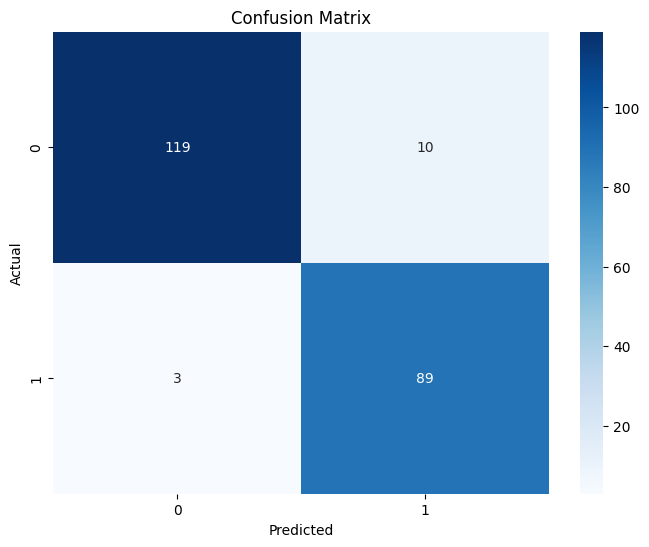

In [9]:
# confusion matrix...

plt.figure(figsize=(8, 6))
confus_matrix = confusion_matrix(y_test, test_predictions)
sns.heatmap(confus_matrix, annot=True, fmt='d', cmap='Blues', )
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

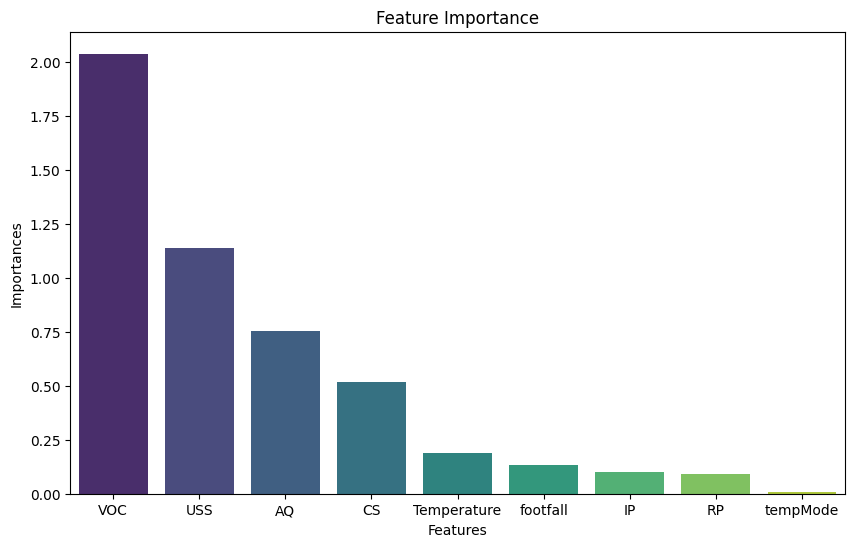

In [10]:
# Feature importance in Bussiness...


if best_model_name == 'Random Forest':
    feature_importance = best_model.feature_importances_
    feature_names = x.columns
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Feature', y='Importances', hue='Feature', data=feature_importance_df.sort_values(by='Importance', ascending=False), palette='viridis', legend=False)

elif best_model_name == 'Logistic Regression':
    feature_importance = np.abs(best_model.coef_).flatten()
    feature_names = x.columns
    feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Feature', y='Importance', hue='Feature', data=feature_importance_df.sort_values(by='Importance', ascending=False), palette='viridis', legend=False)

else:
  perm = permutation_importance(
      best_model, x_val, y_val,
      n_repeats=30, scoring = 'accuracy',
      n_jobs = -1, random_state=42
  )
  feature_importance = perm.importances_mean
  feature_names = x.columns
  feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
  plt.figure(figsize=(10, 6))
  sns.barplot(x='Feature', y='Importance', hue='Feature', data=feature_importance_df.sort_values(by='Importance', ascending=False), palette='viridis', legend=False)

plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importances')
plt.show()